### LIBRARY IMPORTS

In [1]:
# libraries required to run this norebook, can comment out if libraries are already installed
%pip install -q ipywidgets geopandas geoplot geoplot mapclassify vega_datasets urllib3 altair==5.4.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 658.1/658.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.8/180.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 10.3 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings("ignore")

# importing libraries
# data cleaning
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# interactive widgets
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, Layout,VBox
import ipywidgets as widgets


# choropleth maps
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import mapclassify as mc
import altair as alt
from vega_datasets import data

### DATA PROCESSING

The below block of code imports the FEMA dataset from our team's github page. The cell imports the csv into pandas, and intializes lists and dictionaries that will be used in this step and later ones. After tallying disasters by year, month, and state, the final result is a dataframe with all federally declared natural disasters from 1953-2023.

In [3]:
import warnings
warnings.filterwarnings("ignore")

# DISASTER DATASET
disaster_data_link = 'https://raw.githubusercontent.com/xquinnma/milestone/refs/heads/main/DisasterDeclarationsSummaries.csv'

#create dataframe from FEMA disaster declarations summaries csv
file = pd.read_csv(disaster_data_link, low_memory=False)
df = pd.DataFrame(file)

#dictionary to convert state/territory designators to full word strings
state_dict = {'AL':'Alabama','AK':'Alaska','AZ':'Arizona','AR':'Arkansas','CA':'California','CO':'Colorado','CT':'Connecticut',
             'DE':'Delaware', 'FL':'Florida','GA':'Georgia','HI':'Hawaii','ID':'Idaho','IL':'Illinois','IN':'Indiana','IA':'Iowa',
             'KS':'Kansas','KY':'Kentucky','LA':'Louisiana','ME':'Maine','MD':'Maryland','MA':'Massachusetts','MI':'Michigan',
             'MN':'Minnesota','MS':'Mississippi','MO':'Missouri','MT':'Montana','NE':'Nebraska','NV':'Nevada','NH':'New Hampshire',
             'NM':'New Mexico','NY':'New York','NJ':'New Jersey','NC':'North Carolina','ND':'North Dakota','OH':'Ohio',
             'OK':'Oklahoma','OR':'Oregon','PA':'Pennsylvania','RI':'Rhode Island','SC':'South Carolina','SD':'South Dakota',
              'TN':'Tennessee','TX':'Texas','UT':'Utah','VT':'Vermont','VA':'Virginia','WA':'Washington','WV':'West Virginia',
             'WI':'Wisconsin','WY':'Wyoming','DC':'Washington, DC','GU':'Guam','PR':'Puerto Rico','AS':'American Samoa',
             'MP':'Northern Mariana Islands','FM':'Federated States of Micronesia','MH':'Marshall Islands','PW':'Palau'}

#create a list of the 48 contiguous states.  Alaska, Hawaii, DC, and territories are omitted
state_list = ['AL','AZ','AR','CA','CO','CT','DE', 'FL','GA','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI',
             'MN','MS','MO','MT','NE','NV','NH','NM','NY','NJ','NC','ND','OH','OK','OR','PA','RI','SC','SD',
              'TN','TX','UT','VT','VA','WA','WV','WI','WY']

#set using only natural disasters that could be potentially caused by climate change
natural_disaster = ['Fire','Flood','Severe Storm','Straight-Line Winds','Winter Storm','Hurricane','Tornado','Tropical Storm',
                   'Mud/Landslide','Snowstorm','Coastal Storm','Severe Ice Storm','Typhoon','Freezing','Drought','Fishing Losses',
                   'Other', 'Dam/Levee Break','Tropical Depression']

#manmade or other disasters that would not be caused by climate change
nonweather_disaster = ['Earthquake','Other','Biological','Dam/Levee Break','Volcanic Eruption','Toxic Substances','Chemical',
                      'Terrorist','Human Cause','Tsunami','Civil Unrest','Nuclear','Explosion','Tidal Wave']

#dictionary to convert disaster codes to strings representing each type of disaster
disaster_dict = {'0':'Not applicable','1':'Explosion','2':'Straight-Line Winds','3':'Tidal Wave','4':'Tropical Storm',
                '5':'Winter Storm','A':'Tsunami','B':'Biological','C':'Coastal Storm','D':'Drought','E':'Earthquake',
                 'F':'Flood','G':'Freezing','H':'Hurricane','I':'Terrorist','J':'Typhoon','K':'Dam/Levee Break','L':'Chemical',
                'M':'Mud/Landslide','N':'Nuclear','O':'Severe Ice Storm','P':'Fishing Losses','Q':'Crop Losses','R':'Fire',
                'S':'Snowstorm','T':'Tornado','U':'Civil Unrest', 'V':'Volcanic Eruption','W':'Severe Storm','X':'Toxic Substances',
                'Y':'Human Cause','Z':'Other', '8':'Tropical Depression'}


                #select columns necessary for data analysis, add empty columns for each natural disaster type
column_list = ['femaDeclarationString','state','incidentType','incidentBeginDate','fipsStateCode','region',
               'designatedIncidentTypes','declarationTitle']+natural_disaster
df = df.reindex(columns=column_list, fill_value=0)


#convert strings to datetime objects
df['incidentBeginDate']=pd.to_datetime(df['incidentBeginDate'])


#create columns for year, month, and day for later analysis
df['year'] = df['incidentBeginDate'].dt.year
df['month'] = df['incidentBeginDate'].dt.month
df['day'] = df['incidentBeginDate'].dt.day


#select only disasters where primary incident type is in the natural disaster list, only states in CONUS, and only
#in range 1953-2023
disaster_df = df[(df['incidentType'].isin(natural_disaster)) & (df['state'].isin(state_list))
& (df['year'].isin(range(1953,2024)))]

disaster_df.reset_index(inplace = True)


#fill in the missing values in the designatedIncidentTypes column using the indicidentType column
disaster_df['designatedIncidentTypes'].fillna(disaster_df['incidentType'], inplace = True)


#this block uses the incident codes in disaster_dict to populate the respective incident columns in disaster_df
for i in range(0,len(disaster_df)):
    incident = disaster_df.loc[i,'designatedIncidentTypes']
    incident_list = incident.split(',')

    #if there is only one incident type, add 1 to the corresponding column
    if ((len(incident_list) == 1) & (len(incident_list[0])>1)):
        col = incident_list[0]
        try:
            disaster_df.loc[i, col] += 1
        except:
            continue

    #if there are multiple incident types, add 1 to the corresponding column for each
    else:
        #create a new list, this combines the incident list from designatedIncidentTypes and incidentType
        new_list = []
        for inc in incident_list:
            #add longform name to new_list
            if len(inc) == 1:
                new_list.append(disaster_dict[inc])
        #add incidentType to new_list if not already in new_list
        if disaster_df.loc[i, 'incidentType'] not in new_list:
            new_list.append(disaster_df.loc[i, 'incidentType'])
        #ensures that code skips over non-natural disasters
        for val in new_list:
            try:
                disaster_df.loc[i, val] += 1
            except:
                continue


#drop duplicate disaster declarations, this eliminates duplicate county declarations in each state
#NOTE - disasters that cross state boundaries will appear once for each state impacted
disaster_df.drop_duplicates('femaDeclarationString', inplace = True)
disaster_merge_df = disaster_df.drop(columns=['index', 'incidentType','femaDeclarationString','incidentBeginDate','designatedIncidentTypes','declarationTitle','day'])
disaster_merge_df['state'].replace(to_replace=state_dict, inplace=True)


#create a dataframe from groupby that totals the disasters for each month by state.

'''
disaster_group = disaster_merge_df.groupby(by=['year','month','state']).agg(fire = ('Fire','sum'),
                                                                 flood = ('Flood','sum'),
                                                                  severe = ('Severe Storm','sum'),
                                                                  straight_line_winds= ('Straight-Line Winds','sum'),
                                                                  winter_storm = ('Winter Storm','sum'),
                                                                  hurricane = ('Hurricane','sum'),
                                                                  tornado = ('Tornado','sum'),
                                                                  tropical_storm = ('Tropical Storm','sum'),
                                                                  landslide = ('Mud/Landslide','sum'),
                                                                  snowstorm = ('Snowstorm','sum'),
                                                                  coastal_storm = ('Coastal Storm','sum'),
                                                                  ice_storm = ('Severe Ice Storm','sum'),
                                                                  typhoon = ('Typhoon','sum'),
                                                                  freezing = ('Freezing','sum'),
                                                                  drought = ('Drought','sum'),
                                                                  fishing_loss = ('Fishing Losses','sum'),
                                                                   other = ('Other','sum'),
                                                                  dam_break = ('Dam/Levee Break','sum'),
                                                                  tropical_depression = ('Tropical Depression','sum')
                                                                 )

'''

# group datafarme by year, month and state
disaster_group = disaster_merge_df.drop(['fipsStateCode', 'region'], axis=1).groupby(['year','month','state']).sum()

The following block of code imports the weather dataset from our team's github page. The direct links are commented at the top of the block. As of submission date for this project, the NCEI source page (the server is located in Asheville, NC) is down due to Hurricane Helene. The result of this code block is a dataframe with the weather data that is grouped by year, month and state. This will be merged with the disaster dataframe.

In [4]:
#WEATHER DATASET

# collections of data URLs

# Direct Link to NCEI Website, currently down as of 09/30/24
"""
data_url_precipitation = 'https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-pcpnst-v1.0.0-20240906'
data_url_max_temp = 'https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-tmaxst-v1.0.0-20240906'
data_url_min_temp = 'https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-tminst-v1.0.0-20240906'
data_url_avg_temp = 'https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-tmpcst-v1.0.0-20240906'
data_url_phdi = 'https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-phdist-v1.0.0-20240906'
data_url_pdmi = 'https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-pmdist-v1.0.0-20240906'
data_url_pdsi = 'https://www.ncei.noaa.gddov/pub/data/cirs/climdiv/climdiv-pdsist-v1.0.0-20240906'
"""

# Using backup dataset as the NCEI datacenter is currently impacted by Hurricane Helene
# Backup Dataset in Github
data_url_precipitation = 'https://raw.githubusercontent.com/xquinnma/milestone/refs/heads/main/weather_data/climdiv-pcpnst'
data_url_max_temp = 'https://raw.githubusercontent.com/xquinnma/milestone/refs/heads/main/weather_data/climdiv-tmaxst'
data_url_min_temp = 'https://raw.githubusercontent.com/xquinnma/milestone/refs/heads/main/weather_data/climdiv-tminst'
data_url_avg_temp = 'https://raw.githubusercontent.com/xquinnma/milestone/refs/heads/main/weather_data/climdiv-tmpcst'
data_url_phdi = 'https://raw.githubusercontent.com/xquinnma/milestone/refs/heads/main/weather_data/climdiv-phdist'
data_url_pdmi = 'https://raw.githubusercontent.com/xquinnma/milestone/refs/heads/main/weather_data/climdiv-pmdist'
data_url_pdsi = 'https://raw.githubusercontent.com/xquinnma/milestone/refs/heads/main/weather_data/climdiv-pdsist'


# column names for the data URLs - Month 1 to 12
data_column_names = ['id', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

# dictionary for state code and state names
state_code_dict = {
    '1':'Alabama', '2':'Arizona', '3':'Arkansas', '4':'California', '5':'Colorado',
    '6':'Connecticut', '7':'Delaware', '8':'Florida', '9':'Georgia', '10':'Idaho',
    '11':'Illinois', '12':'Indiana', '13':'Iowa', '14':'Kansas', '15':'Kentucky',
    '16':'Louisiana', '17':'Maine', '18':'Maryland', '19':'Massachusetts', '20':'Michigan',
    '21':'Minnesota', '22':'Mississippi', '23':'Missouri', '24':'Montana', '25':'Nebraska',
    '26':'Nevada', '27':'New Hampshire', '28':'New Jersey', '29':'New Mexico', '30':'New York',
    '31':'North Carolina', '32':'North Dakota', '33':'Ohio', '34':'Oklahoma', '35':'Oregon',
    '36':'Pennsylvania', '37':'Rhode Island', '38':'South Carolina', '39':'South Dakota', '40':'Tennessee',
    '41':'Texas', '42':'Utah', '43':'Vermont', '44':'Virginia', '45':'Washington',
    '46':'West Virginia', '47':'Wisconsin', '48':'Wyoming'
                   }


#function that cleans data

def format_df(input_url, feature_name, start_year=1953, end_year=2023):
    df = pd.read_csv(input_url, header=None, names=data_column_names, delimiter=r"\s+", dtype= str)
    df = df.set_index('id').stack().reset_index().rename(columns={'level_1':'month', 0:feature_name})

    # create columns for state code and year from id column
    # convert year and month to datetime data
    df['state_code'] = df['id'].astype(str).str[:3].astype(int)
    df['year'] = pd.to_datetime(df['id'].astype(str).str[-4:]).dt.year
    df['month'] = pd.to_datetime(df['month'], format='%m').dt.month

    # limit state code < 48 is continental US
    df = df[df['state_code'] < 49]
    # limit data between year 1953 and 2023
    df = df[(df['year'] >= start_year) & (df['year'] <= end_year)]

    # convert state code to state name
    df['state'] = df['state_code'].astype(str).map(state_code_dict)

    # dropping unnecessary coloumns and shuffle column order and reset index
    df = df.drop(['id', 'state_code'], axis=1)

    # convert column to floats
    df = df.astype({feature_name : 'float'})

    # reorder columns
    df = df[['year', 'month', 'state', feature_name]].reset_index(drop=True)

    #print(df.dtypes)

    return df.copy()



# creating individual dataframes for each feature
df_precipitation = format_df(data_url_precipitation, 'precipitation')
df_max_temp =   format_df(data_url_max_temp, 'max_temp')
df_min_temp = format_df(data_url_min_temp, 'min_temp')
df_avg_temp = format_df(data_url_avg_temp, 'avg_temp')
df_phdi = format_df(data_url_phdi, 'pdhi')
df_phmi = format_df(data_url_pdmi, 'pdmi')
df_pdsi = format_df(data_url_pdsi, 'pdsi')

# combine all data
df_all_list = [df_precipitation, df_max_temp, df_min_temp, df_avg_temp, df_phdi, df_phmi, df_pdsi]

df_combined = df_all_list[0].copy()

for i in range(len(df_all_list)):
    if i!=0:
        df_combined = pd.merge(df_combined, df_all_list[i], on=['year', 'month', 'state'])


df_combined_grouped = df_combined.groupby(['year', 'month', 'state']).sum()


The following block of code merges both the disaster and weather data into one final dataframe.  It is this dataframe that we will use for analysis and visualizations.  At this stage, we add the region labels back into the dataframe.  This allows for comparisons across FEMA regions, and not just individual states.

In [5]:
#COMBINE INTO ONE DATASET

weather_df = df_combined_grouped.copy()
disaster = disaster_group.copy()

full_df = (disaster.join(weather_df, how = 'outer'))
full_df.fillna(0, inplace = True)


# get possible regions codes from dataset
states_region_df = disaster_merge_df[['state', 'region']].drop_duplicates()
region_codes = sorted(states_region_df.drop_duplicates()['region'].unique().tolist())

# build a dictionary of region codes and state names
state_region_dict = {}
for i in region_codes:
    states_list = states_region_df[states_region_df['region']==i]['state'].values
    for j in states_list:
        state_region_dict[j] = i

# adding region column back into the merged dataset
full_df = full_df.reset_index()
full_df['region'] = full_df['state'].map(state_region_dict)

# showing the full dataframe
#full_df.groupby(['region','year','state']).sum().head(20)


In [6]:
# define columns for weather data features and disaster type features
weather_features = weather_df.columns.values.tolist()
disaster_features = disaster_group.columns.values.tolist()
other_features = ['year','month', 'state', 'region']

# reordering columns of the full_df
full_df = full_df[other_features + disaster_features  + weather_features]

### VISUALIZATION

The following series of visualizations helps answer our research questions.  Some of the visualizations are interactive, so feel free to explore the data yourself!

Q1. Are natural disasters becoming more frequent?

Visualization - Bar Chart of Total Number of Disasters Between 1953 and 2023 CONUS

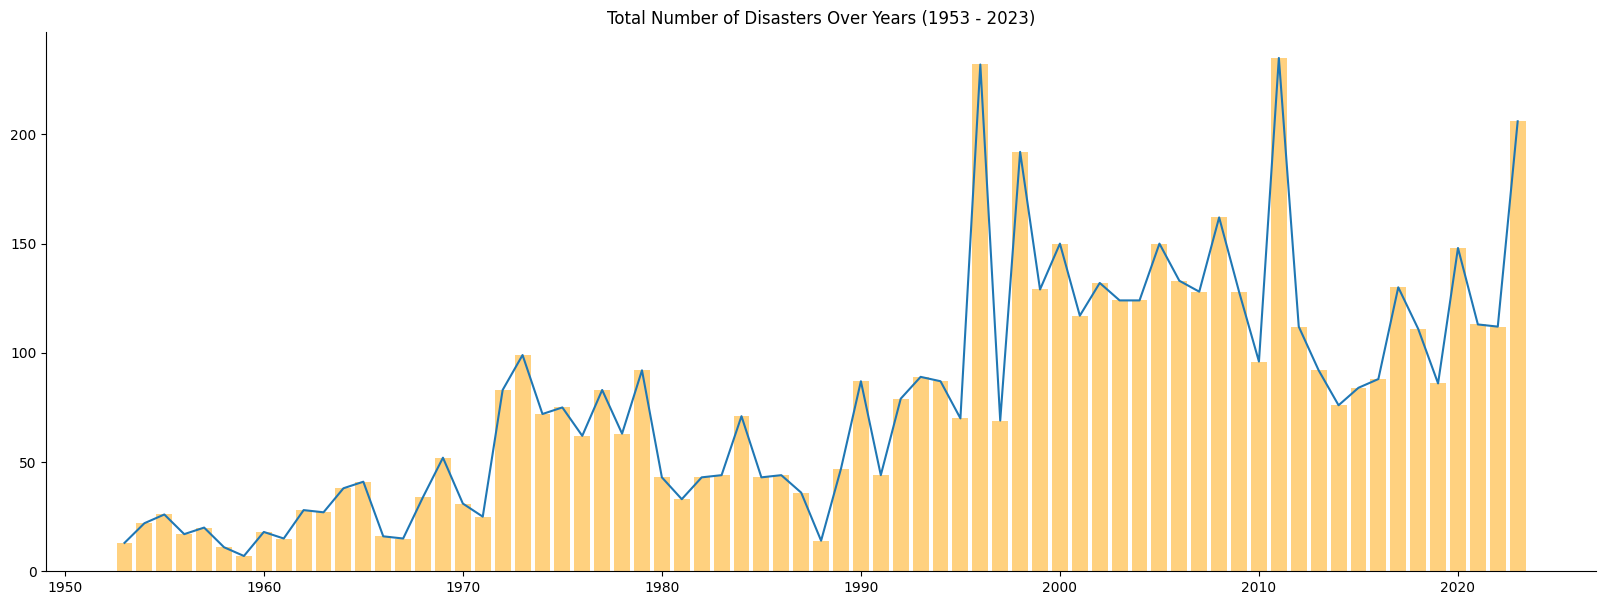

In [7]:
# get total number of disasters grouped by year
sum_disaster_by_year = full_df[other_features + disaster_features].drop(['month','state','region'], axis=1).groupby('year').sum().T.sum()

f, ax = plt.subplots(figsize=(20,7))
ax.bar(sum_disaster_by_year.index, sum_disaster_by_year, color='orange', alpha=0.5)
ax.plot(sum_disaster_by_year.index, sum_disaster_by_year)

# remove borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Total Number of Disasters Over Years (1953 - 2023)')
plt.show()

A1:

Overall there seems to be an increasing number of disasters between 1953 and 2023. Disasters seems to happen more frequently than it used to be.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Q2. What types of natural disasters are becoming more frequent?

Visualization - Horizontal Bar Chart Showing the Total Number Of Disaster Occurrences by Type

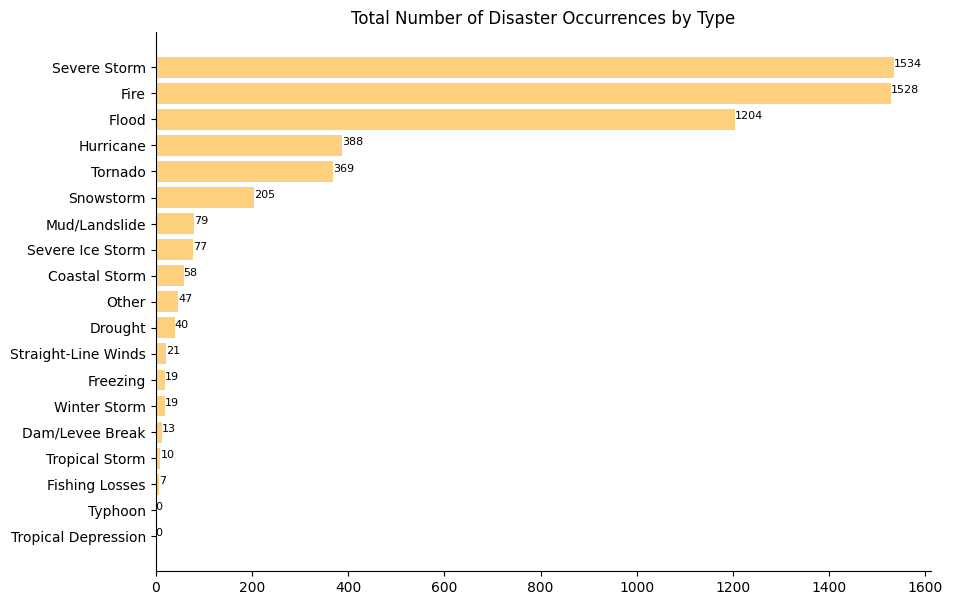

In [8]:
# get sum of disaster by type and sort by most frequent first
sum_disaster_by_type = full_df[disaster_features].sum().sort_values(ascending=True)

f, ax = plt.subplots(figsize=(10,7))
ax.barh(sum_disaster_by_type.index, sum_disaster_by_type, color='orange', alpha=0.5)

# show number of disasters on bar graph
for index, value in enumerate(sum_disaster_by_type):
    plt.text(value, index, str(int(value)), size=8)

# remove borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Total Number of Disaster Occurrences by Type')
plt.show()

Visualization - Interactive Graph Showing Trend of The Number of Occurrences of Each Type of Disasters Between 1953 and 2023

In [9]:
disaster_selection = widgets.Dropdown(options=sorted(disaster_features), value=sorted(disaster_features)[0], description='Disaster Type:', disabled=False)

def draw_graph(selected_disaster):
    # create dataframe of disasters grouped by year and separated by type
    sum_disaster_by_type_and_year = full_df[other_features + disaster_features].drop(['month','state','region'], axis=1).groupby('year').sum()

    f, ax = plt.subplots(figsize=(15,7))
    ax.plot(sum_disaster_by_type_and_year.index, sum_disaster_by_type_and_year[selected_disaster])
    ax.bar(sum_disaster_by_type_and_year.index, sum_disaster_by_type_and_year[selected_disaster], color='orange', alpha=0.5)

    # remove borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.title('The Number of Occurrences of ' + selected_disaster + ' Over Years (1953 - 2023)')
    plt.show()

interactive(draw_graph, selected_disaster = disaster_selection)

interactive(children=(Dropdown(description='Disaster Type:', options=('Coastal Storm', 'Dam/Levee Break', 'Dro…

A2:

The top 5 disaster with most number of occurances are:
- Severe Storm
- Fire
- Flood
- Hurricane
- Tornado

Over the past 30 years, there seems to be an increased amount of disasters occuring. However, there is no clear pattern showing consistent increase.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Q3. Is this change similar across different regions (see map below)?

Visualization - Stacked Bar Chart Showing The Total Number Of Disaster Occurrences CONUS Color Coded By Disaster Type Among 10 Regions

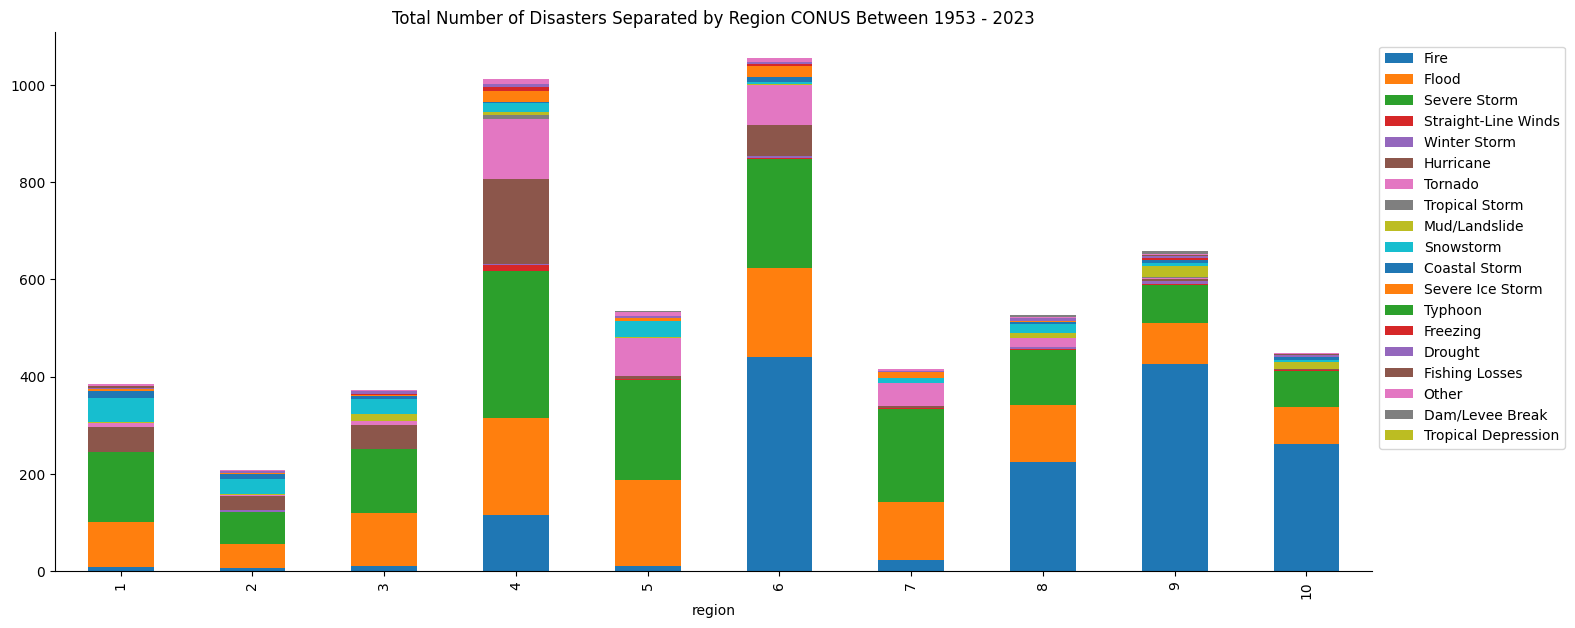

In [10]:
types_of_disaster_by_region = full_df[other_features + disaster_features].drop(['year','month','state'], axis=1).groupby('region').sum().sort_index().reset_index()
f_q3 = types_of_disaster_by_region.plot(x='region', kind='bar', stacked=True, figsize=(17,7))
f_q3.legend(loc='center left', bbox_to_anchor=(1,0.6))

# remove borders
f_q3.spines['top'].set_visible(False)
f_q3.spines['right'].set_visible(False)

plt.title('Total Number of Disasters Separated by Region CONUS Between 1953 - 2023')
plt.show()

Visualization - Horizontal Bar Chart Showing the Total Number of Disaster Occurrences by Region

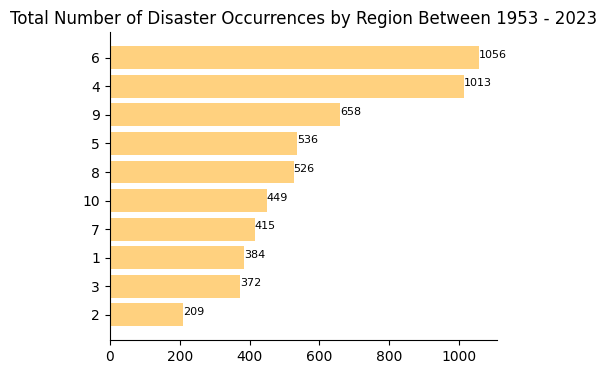

In [11]:
sum_disaster_by_region = full_df[other_features + disaster_features].drop(['year','month','state'], axis=1).groupby('region').sum().T.sum().sort_values(ascending=True)

f, ax = plt.subplots(figsize=(5,4))
ax.barh(sum_disaster_by_region.index.astype('str'), sum_disaster_by_region, color='orange', alpha=0.5)

# show number of disasters on bar graph
for index, value in enumerate(sum_disaster_by_region):
    plt.text(value, index, str(int(value)), size=8)

# remove borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Total Number of Disaster Occurrences by Region Between 1953 - 2023')
plt.show()

In [12]:
# getting location dataset for the map plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))

# geo data for map plotting
conus_geo_data = contiguous_usa[['state','geometry']]
conus_geo_data_dict = {}

# dictionary for
for i in conus_geo_data['state']:
    conus_geo_data_dict[i] = conus_geo_data[conus_geo_data['state']==i]['geometry'].values[0]

Visualization - Overall Map Showing The Number of Disasters CONUS Between 1953 and 2023

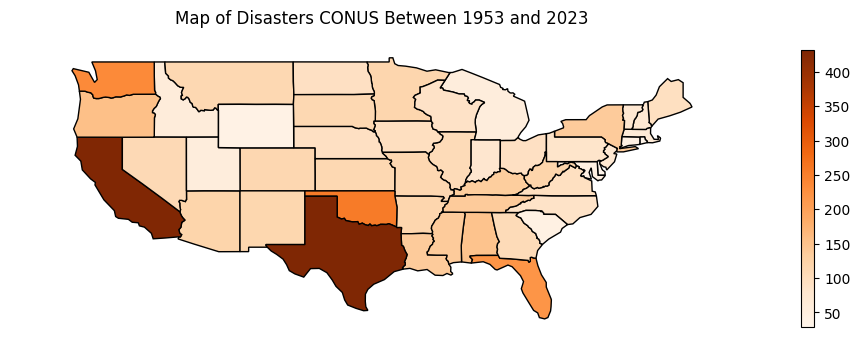

In [13]:
sum_disaster_by_state = gpd.GeoDataFrame(full_df[other_features + disaster_features].drop(['year','region','month'], axis=1).groupby('state').sum().T.sum()).rename(columns={0:'disaster_total'})
sum_disaster_by_state['geometry'] = sum_disaster_by_state.index.map(conus_geo_data_dict)
f = gplt.choropleth(sum_disaster_by_state, hue='disaster_total', cmap='Oranges', legend=True, figsize=(12,12), legend_kwargs={'shrink': 0.3})
f.set_title('Map of Disasters CONUS Between 1953 and 2023')
plt.show()

Visualization - Interactive Map Showing The Number of Disasters CONUS by Year

In [14]:
# interactive graph to see the number of disasters each year CONUS
sum_disaster_by_state_and_year = gpd.GeoDataFrame(full_df[other_features + disaster_features].drop(['region','month'], axis=1).groupby(['year','state']).sum().T.sum()).rename(columns={0:'disaster_total'}).reset_index()
sum_disaster_by_state_and_year['geometry'] = sum_disaster_by_state_and_year['state'].map(conus_geo_data_dict)
year_selection = widgets.IntSlider(value=1953, min=1953, max=2023, description="Year")

def draw_graph_map(selected_year):
    # create df based on selected year on the widget
    selected_year_df = sum_disaster_by_state_and_year[sum_disaster_by_state_and_year['year'] == selected_year]

    f = gplt.choropleth(selected_year_df, hue='disaster_total', cmap='Oranges', legend=True, figsize=(12,12), legend_kwargs={'shrink': 0.3})
    f.set_title('Map of Disasters CONUS in Year ' + str(selected_year))
    plt.show()

interactive(draw_graph_map, selected_year=year_selection)

interactive(children=(IntSlider(value=1953, description='Year', max=2023, min=1953), Output()), _dom_classes=(…

A3:


Yes, regions 6 and 4 are most prone to natural disasters. Both exceeded 1,000 between 1953 and 2023.

This finding is corroborated with the map showing states like Texas, California have the highest number of natural disaster occurrences, then followed by Washington, Oklahoma and Florida.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Q4. Are there changes in disaster frequency based on time of year?

Stacked Bar Chart Showing the Total Number of Disasters in Different Months Between 1953 and 2023

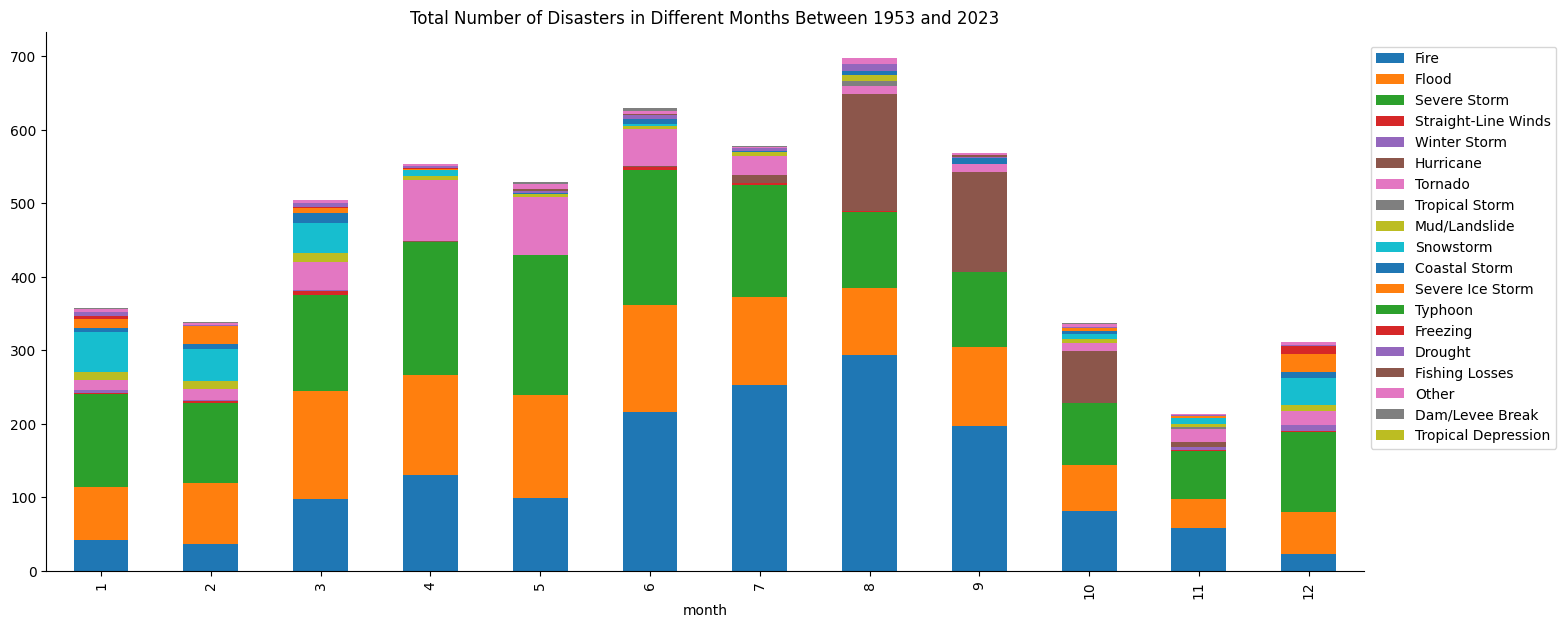

In [15]:
# create dataframe of disaster data grouped by month
sum_disaster_by_month = full_df[other_features + disaster_features].drop(['year','region','state'], axis=1).groupby('month').sum().reset_index()

# plotting stacked bar chart to show the total number of disaster occurrences between 1953 and 2023
f_q4 = sum_disaster_by_month.plot(x='month', kind='bar', stacked=True, figsize=(17,7))
f_q4.legend(loc='center left', bbox_to_anchor=(1,0.6))

# remove borders
f_q4.spines['top'].set_visible(False)
f_q4.spines['right'].set_visible(False)

plt.title('Total Number of Disasters in Different Months Between 1953 and 2023')
plt.show()

A4:

Seems like the in the summer months - June, July, August and September, the number of disasters increased. The number of 'Fire' disasters shows the most amount of increase in these months.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Additional Visualizations

Interactive Line + Bar Chart Trying to Discover Relations Between Weather Data and Disasters

interactive(children=(Dropdown(description='States:', options=('Alabama', 'Arizona', 'Arkansas', 'California',…

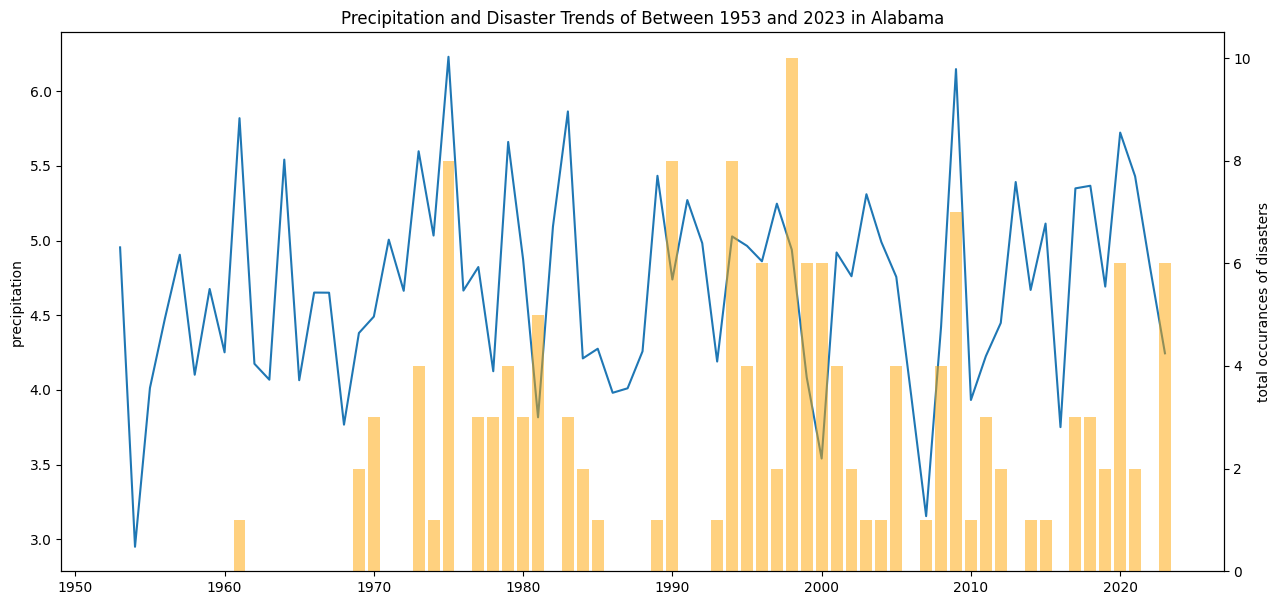

In [16]:
# list of states and features
list_of_states = full_df.reset_index()['state'].unique()

# drop down menus of options
state_selection = widgets.Dropdown(options=list_of_states, value=list_of_states[0], description='States:', disabled=False)
weather_features_selection = widgets.Dropdown(options=weather_features, value=weather_features[0], description='Features:', disabled=False)

#selected_state = "California"
#selected_weather_feature = 'avg_temp'

def draw_graph(selected_state, selected_weather_feature):
    # create dataframe with average weather data based on year in selected state
    selected_weather_df = full_df[other_features + weather_features].drop(['month', 'region'], axis=1)
    selected_weather_df = selected_weather_df[selected_weather_df['state']==selected_state]
    selected_weather_df = selected_weather_df.drop('state', axis=1).groupby('year').mean().reset_index()

    # create dataframe with total number of disasters of the selected state
    selected_disaster_df = full_df[other_features + disaster_features].drop(['month', 'region'], axis=1)
    selected_disaster_df = selected_disaster_df.groupby(['year','state']).sum().T.sum().reset_index().rename(columns={0:'disaster_total'})
    selected_disaster_df = selected_disaster_df[selected_disaster_df['state'] == selected_state]

    # plotting line graph of weather data
    fig, ax1 = plt.subplots(figsize=(15, 7))
    ax1.set_ylabel(selected_weather_feature)
    f1 = plt.plot(selected_weather_df['year'], selected_weather_df[selected_weather_feature])
    ax1.tick_params(axis='y')

    # plotting bar chart of disaster data
    ax2 = ax1.twinx()
    ax2.set_ylabel('total occurances of disasters')
    f2 = plt.bar(selected_disaster_df['year'], selected_disaster_df['disaster_total'],  color='orange', alpha=0.5)
    ax2.tick_params(axis='y')
    plt.title(selected_weather_feature.capitalize() + " and Disaster Trends of Between 1953 and 2023 in " + selected_state)

plt.show()

interactive(draw_graph, selected_state = state_selection, selected_weather_feature = weather_features_selection)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Scatter Plot with Best Fit Line Showing Relation between Weather Data and Disaster Occurrences

In [17]:
disaster_year_count = full_df[other_features + disaster_features].drop(['state','region','month'], axis=1).groupby('year').sum().T.sum()
weather_year_avg_df = full_df[other_features + weather_features].drop(['state','region','month'], axis=1).groupby('year').mean()

weather_features_selection = widgets.Dropdown(options=weather_features, value=weather_features[0], description='Features:', disabled=False)

def plot_weather_vs_disaster(selected_weather_feature):

    fig, ax1 = plt.subplots(figsize=(10, 5))
    plt.title('Relation between ' + str(selected_weather_feature).capitalize() + ' and Disaster Occurrences CONUS')
    a, b = np.polyfit(disaster_year_count, weather_year_avg_df[selected_weather_feature], 1)
    plt.scatter(weather_year_avg_df[selected_weather_feature], disaster_year_count)
    plt.plot(a * disaster_year_count + b,disaster_year_count, color='orange', alpha=0.5)
    ax1.set_ylabel('Number of Disaster Occurrences')
    ax1.set_xlabel('Average ' + selected_weather_feature.capitalize())
    plt.show()

interactive(plot_weather_vs_disaster, selected_weather_feature = weather_features_selection)

interactive(children=(Dropdown(description='Features:', options=('precipitation', 'max_temp', 'min_temp', 'avg…

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

The following visualization allows you to compare weather features versus disaster type for a particular state.

interactive(children=(Dropdown(description='States:', options=('Alabama', 'Arizona', 'Arkansas', 'California',…

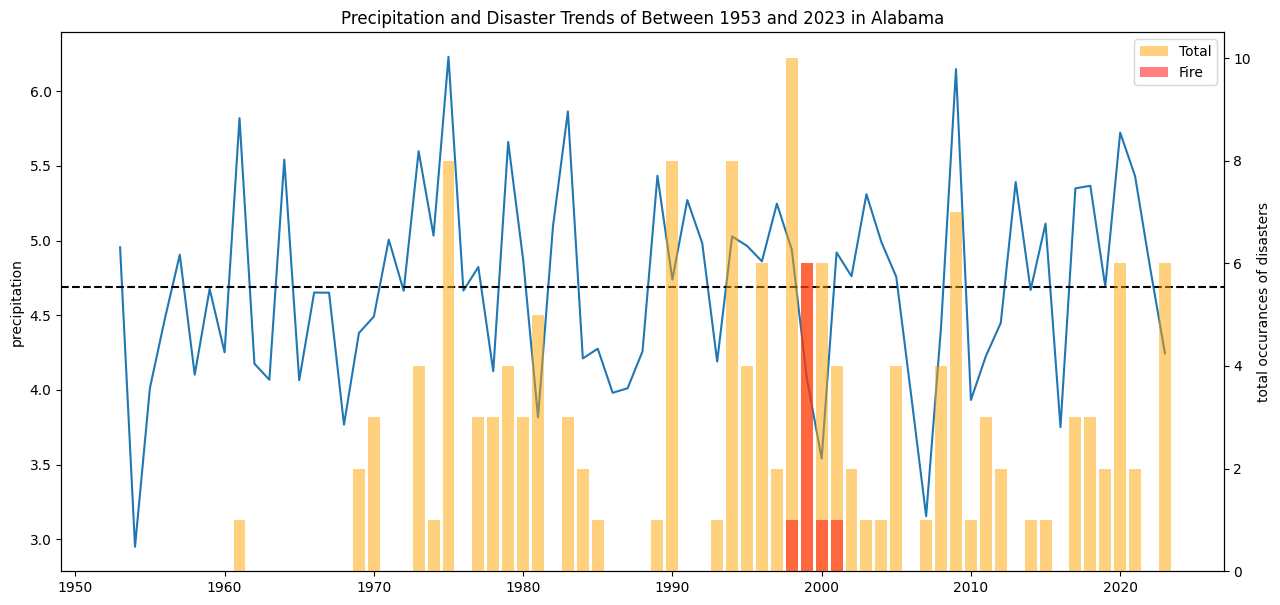

In [18]:
# list of states and features

list_of_states = full_df.reset_index()['state'].unique()

# drop down menus of options
state_selection = widgets.Dropdown(options=list_of_states, value=list_of_states[0], description='States:', disabled=False)
weather_features_selection = widgets.Dropdown(options=weather_features, value=weather_features[0], description='Features:', disabled=False)
disaster_features_selection = widgets.Dropdown(options=disaster_features, value=disaster_features[0], description='Features:', disabled=False)

#selected_state = "California"
#selected_weather_feature = 'avg_temp'

def draw_graph(selected_state, selected_weather_feature, selected_disaster):
    # create dataframe with average weather data based on year in selected state
    selected_weather_df = full_df[other_features + weather_features].drop(['month', 'region'], axis=1)
    selected_weather_df = selected_weather_df[selected_weather_df['state']==selected_state]
    selected_weather_df = selected_weather_df.drop('state', axis=1).groupby('year').mean().reset_index()

    # create dataframe with total number of disasters of the selected state
    selected_disaster_df = full_df[other_features + disaster_features].drop(['month', 'region'], axis=1)
    selected_disaster_df = selected_disaster_df.groupby(['year','state']).sum().T.sum().reset_index().rename(columns={0:'disaster_total'})
    selected_disaster_df = selected_disaster_df[selected_disaster_df['state'] == selected_state]

    # plotting line graph of weather data
    fig, ax1 = plt.subplots(figsize=(15, 7))
    ax1.set_ylabel(selected_weather_feature)
    f1 = plt.plot(selected_weather_df['year'], selected_weather_df[selected_weather_feature])
    ax1.tick_params(axis='y')

    # baseline average of selected weather feature in selected state between 1953 and 2023
    plt.axhline(y=(selected_weather_df.mean()[selected_weather_feature].item()), linestyle='--', color='black')

    # plotting bar chart of total number of disaster data (all disasters)
    ax2 = ax1.twinx()
    ax2.set_ylabel('total occurances of disasters')
    f2 = plt.bar(selected_disaster_df['year'], selected_disaster_df['disaster_total'],  color='orange', alpha=0.5)
    ax2.tick_params(axis='y')
    plt.title(selected_weather_feature.capitalize() + " and Disaster Trends of Between 1953 and 2023 in " + selected_state)

    # plotting bar chart of specific number of disaster data (selected disasters)
    ind_selected_disaster_df = full_df[other_features + disaster_features].drop(['month', 'region'], axis=1)
    ind_selected_disaster_df = ind_selected_disaster_df.groupby(['year','state']).sum().reset_index()
    ind_selected_disaster_df = ind_selected_disaster_df[ind_selected_disaster_df['state'] == selected_state]
    plt.bar(ind_selected_disaster_df['year'], ind_selected_disaster_df[selected_disaster], color='red', alpha=0.5)
    plt.legend(['Total', selected_disaster])


plt.show()

interactive(draw_graph, selected_state = state_selection, selected_weather_feature = weather_features_selection, selected_disaster=disaster_features_selection)

Choropleth encoding the yearly average Palmer Drought Severity Index from 1953 to 2023

PLEASE NOTE: This visualization requires version 5 or higher to run. Successfully testeed with altair 5.4.1 while altair 4.2.2 ran into errors

In [19]:
#Dict of FIPS standard codes for each state, which the altair cholorpleth uses to match geolocation
fips_codes = {'Alabama': 1, 'Alaska':2, 'Arizona': 4, 'Arkansas': 5, 'California': 6, 'Colorado': 8, 'Connecticut': 9,
              'Delaware': 10, 'District of Columbia': 11, 'Florida': 12, 'Georgia': 13, 'Hawaii': 15, 'Idaho': 16, 'Illinois': 17,
              'Indiana': 18, 'Iowa': 19, 'Kansas': 20, 'Kentucky': 21, 'Louisiana': 22, 'Maine': 23, 'Maryland': 24,
              'Massachusetts': 25, 'Michigan': 26, 'Minnesota': 27, 'Mississippi': 28, 'Missouri': 29, 'Montana': 30,
              'Nebraska': 31, 'Nevada': 32, 'New Hampshire': 33, 'New Jersey': 34, 'New Mexico': 35, 'New York': 36,
              'North Carolina': 37, 'North Dakota': 38, 'Ohio': 39, 'Oklahoma': 40, 'Oregon': 41, 'Pennsylvania': 42,
              'Rhode Island': 44, 'South Carolina': 45, 'South Dakota': 46, 'Tennessee': 47, 'Texas': 48, 'Utah': 49,
              'Vermont': 50, 'Virginia': 51, 'Washington': 53, 'West Virginia': 54, 'Wisconsin': 55, 'Wyoming': 56}

#Creating new df with the year, month, state, and pdsi values
#then groups by year and state resulting in yearly mean pdsi
pdsi_df = full_df[['year', 'month', 'state','pdsi']]
pdsi_yearly_df = pdsi_df.groupby(by = ['year', 'state']).mean().reset_index()
#create new column mapping each state with it's FIPS code
pdsi_yearly_df['id'] = pdsi_yearly_df['state'].map(fips_codes)
#uncomment below to see sample of dataframe
#pdsi_yearly_df.sample(10)

#Disabling max rows for altair transformer
alt.data_transformers.disable_max_rows()
#creating slider and selection for choropleth
slider = alt.binding_range(min=1953, max=2023, step=1)
year_selection = alt.selection_single(name="year", fields=['year'],
bind=slider, value={'year': 1985})
#getting state boundaries for choropleth
states = alt.topo_feature(data.us_10m.url, 'states')
#creating interactive choropleth with time slider per year
pdsi_choropleth = alt.Chart(pdsi_yearly_df).mark_geoshape().encode(
    color = 'pdsi:Q',
    tooltip = ['state:N','pdsi:Q'],
).add_selection(
    year_selection
).transform_filter(
    year_selection
).transform_lookup(
    lookup = 'id',
    from_ = alt.LookupData(states, 'id', ["type", "properties", "geometry"])
).project(
    type = 'albersUsa'
).properties(
    width = 500,
    height = 300,
    title = 'Average Yearly PDSI'
)

pdsi_choropleth

alt.Chart(...)

The following map shows average yearly PDSI.  A higher positive value indicates wetter conditions.  A lower negative value indicates drier conditions.